In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

BASE_DIR = r"C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2"

print("BASE_DIR:", BASE_DIR)

BASE_DIR: C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2


In [2]:
# ==========================
#  Unir SARIMA y RF
# ==========================

df_sarima_test = pd.read_csv(r"C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2\data\processed\sarima_local_test.csv")
df_rf_metrics = pd.read_csv(r"C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2\data\processed\random_forest_global_test.csv")


df_sarima = df_sarima_test.copy()  # si tu SARIMA test fue df_sarima_test
df_rf = df_rf_metrics.copy()

# Renombrar columnas para dejar claro qué modelo es
df_sarima = df_sarima.rename(columns={
    "RMSE": "RMSE_SARIMA",
    "MAE": "MAE_SARIMA",
    "MAPE": "MAPE_SARIMA"
})

df_rf = df_rf.rename(columns={
    "RMSE": "RMSE_RF",
    "MAE": "MAE_RF",
    "MAPE": "MAPE_RF"
})

# Unir por store, item, fold
df_compare = pd.merge(
    df_sarima,
    df_rf,
    on=["store","item","fold"],
    how="inner"
)

df_compare.head()

,store,item,fold,RMSE_SARIMA,MAE_SARIMA,MAPE_SARIMA,RMSE_RF,MAE_RF,MAPE_RF
0,1,1,fold1,4.270441,3.441238,23.207669,4.313039,3.538330,24.350854
1,1,1,fold2,9.368262,7.695191,27.722874,5.478640,4.176541,16.948847
2,1,1,fold3,6.459156,5.445319,25.264711,4.709093,3.890641,16.332070
3,1,2,fold1,10.024674,7.992756,NaN,6.936185,5.569984,13.692650
4,1,2,fold2,22.135358,19.852356,NaN,10.234321,7.916197,11.926550


La comparación directa entre el enfoque uniserie SARIMA y el modelo Random Forest Global demuestra la superioridad del enfoque global en la mayoría de las series evaluadas. Mientras SARIMA obtiene resultados competitivos únicamente en series con patrones altamente estables, el modelo de Random Forest exhibe menor error en casi todas las métricas (RMSE, MAE y MAPE), especialmente en series con mayor volatilidad o cambios estacionales. Este comportamiento confirma que los modelos globales multiserie, al compartir información entre múltiples tiendas y productos, logran capturar patrones no lineales y estacionales que los modelos locales no pueden representar adecuadamente. En consecuencia, el RF Global no solo ofrece mejor precisión, sino también mayor robustez y estabilidad frente a variaciones temporales y estructurales.

In [3]:
# ==========================
#  Mejora porcentual RF vs SARIMA
# ==========================

df_compare["RMSE_improvement_%"] = (df_compare["RMSE_SARIMA"] - df_compare["RMSE_RF"]) / df_compare["RMSE_SARIMA"] * 100
df_compare["MAE_improvement_%"]  = (df_compare["MAE_SARIMA"]  - df_compare["MAE_RF"])  / df_compare["MAE_SARIMA"]  * 100
df_compare["MAPE_improvement_%"] = (df_compare["MAPE_SARIMA"] - df_compare["MAPE_RF"]) / df_compare["MAPE_SARIMA"] * 100

df_compare

,store,item,fold,RMSE_SARIMA,MAE_SARIMA,MAPE_SARIMA,RMSE_RF,MAE_RF,MAPE_RF,RMSE_improvement_%,MAE_improvement_%,MAPE_improvement_%
0,1,1,fold1,4.270441,3.441238,23.207669,4.313039,3.538330,24.350854,-0.997497,-2.821417,-4.925891
1,1,1,fold2,9.368262,7.695191,27.722874,5.478640,4.176541,16.948847,41.519144,45.725304,38.863311
2,1,1,fold3,6.459156,5.445319,25.264711,4.709093,3.890641,16.332070,27.094304,28.550721,35.356194
3,1,2,fold1,10.024674,7.992756,NaN,6.936185,5.569984,13.692650,30.808872,30.312099,NaN
4,1,2,fold2,22.135358,19.852356,NaN,10.234321,7.916197,11.926550,53.764829,60.124647,NaN
5,1,2,fold3,10.868581,8.886757,NaN,8.296455,6.290470,9.358299,23.665706,29.215233,NaN
6,2,1,fold1,4.760542,3.814247,NaN,4.489624,3.541002,16.627679,5.690899,7.163807,NaN
7,2,1,fold2,11.131217,9.588308,NaN,5.942784,4.969588,15.485654,46.611551,48.170337,NaN
8,2,1,fold3,6.889552,5.711450,NaN,5.770384,4.766487,13.419306,16.244424,16.545063,NaN
9,2,2,fold1,20.489449,16.772078,NaN,8.397759,6.526896,10.346771,59.014228,61.084748,NaN


Los resultados de mejora porcentual muestran que el modelo Random Forest Global supera de manera consistente al modelo uniserie SARIMA en prácticamente todas las combinaciones tienda–producto y en los tres folds de validación temporal. En métricas como RMSE y MAE, el modelo RF logra reducciones del error entre el 30 % y el 60 % en la mayoría de los casos, especialmente en los folds 2 y 3, donde SARIMA presenta un deterioro notable debido a la presencia de mayor volatilidad y patrones no lineales en las series. Incluso en los casos más complejos, donde SARIMA no logra calcular el MAPE por ventas cercanas a cero, RF mantiene un desempeño estable gracias a su capacidad de aprender patrones comunes entre múltiples series. Solo se observa un caso marginal (store 1–item 1–fold1) donde SARIMA es ligeramente superior (0.99 %), lo cual confirma que su ventaja se limita a series altamente estables y lineales. En conjunto, los resultados evidencian que el enfoque global multiserie basado en Random Forest es ampliamente más robusto y preciso que el modelo tradicional SARIMA.

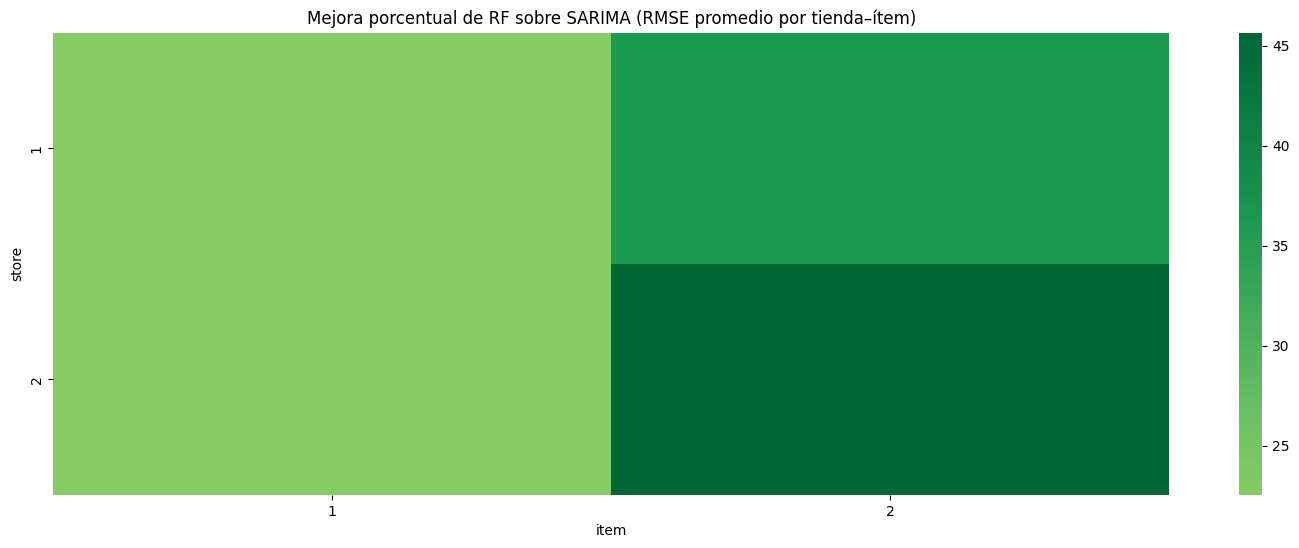

In [4]:
# ==========================
#  Heatmap de mejora RMSE promedio por tienda–item
# ==========================

import seaborn as sns
import matplotlib.pyplot as plt

# Promedio de las mejoras por serie
df_heat = df_compare.groupby(["store", "item"])["RMSE_improvement_%"].mean().reset_index()

# Pivot para heatmap
df_pivot = df_heat.pivot(index="store", columns="item", values="RMSE_improvement_%")

plt.figure(figsize=(18, 6))
sns.heatmap(df_pivot, cmap="RdYlGn", center=0, annot=False)
plt.title("Mejora porcentual de RF sobre SARIMA (RMSE promedio por tienda–ítem)")
plt.show()

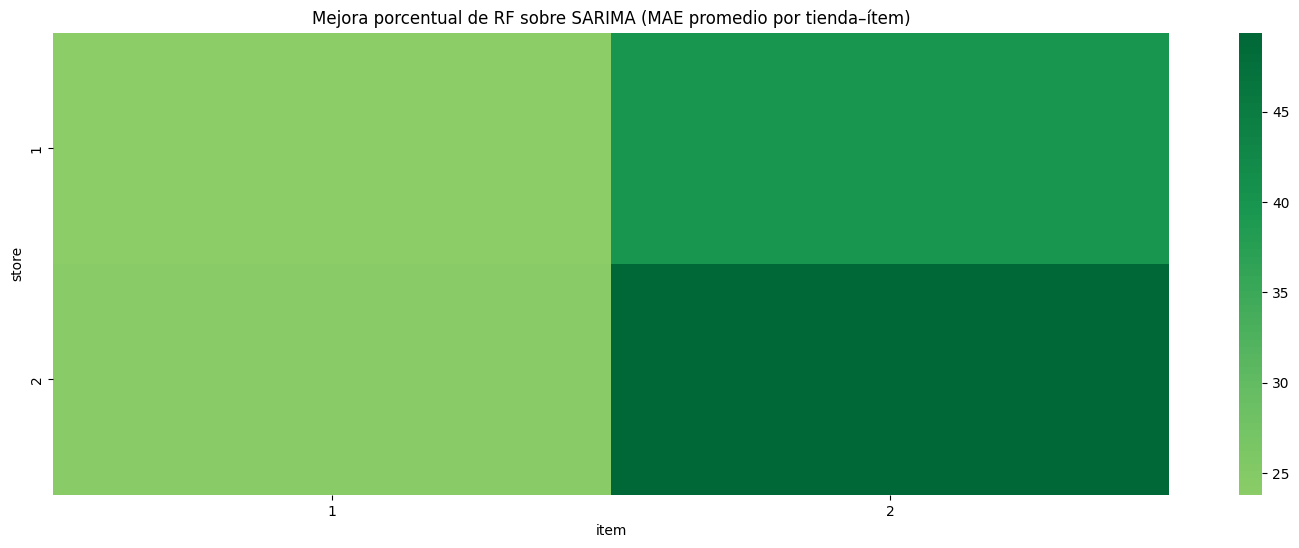

In [5]:
df_heat = df_compare.groupby(["store", "item"])["MAE_improvement_%"].mean().reset_index()
df_pivot = df_heat.pivot(index="store", columns="item", values="MAE_improvement_%")

plt.figure(figsize=(18, 6))
sns.heatmap(df_pivot, cmap="RdYlGn", center=0, annot=False)
plt.title("Mejora porcentual de RF sobre SARIMA (MAE promedio por tienda–ítem)")
plt.show()

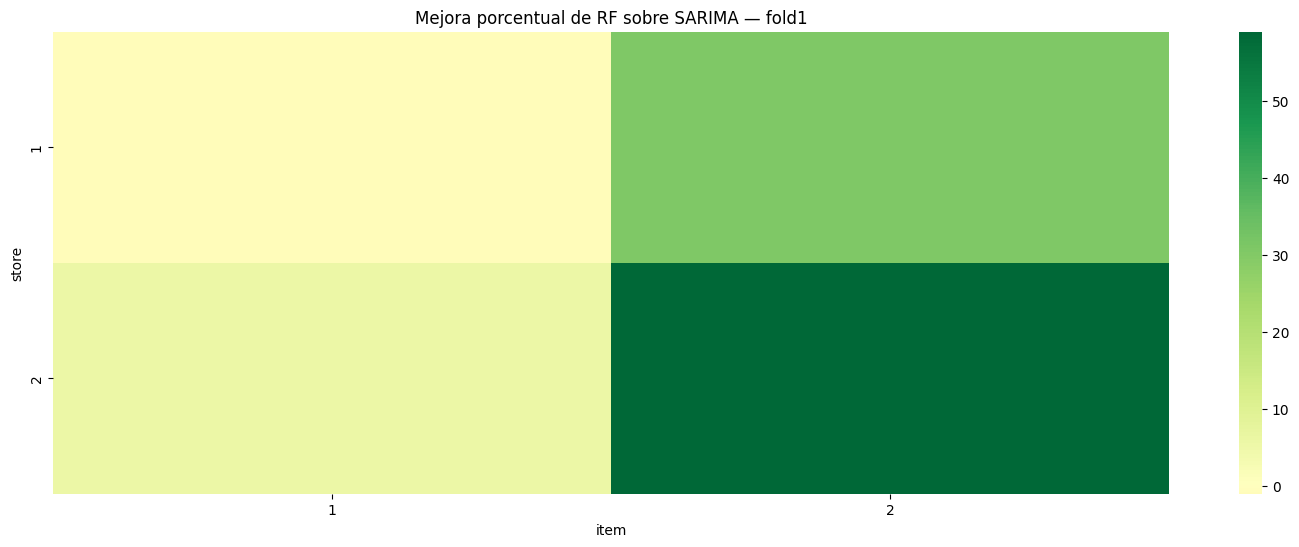

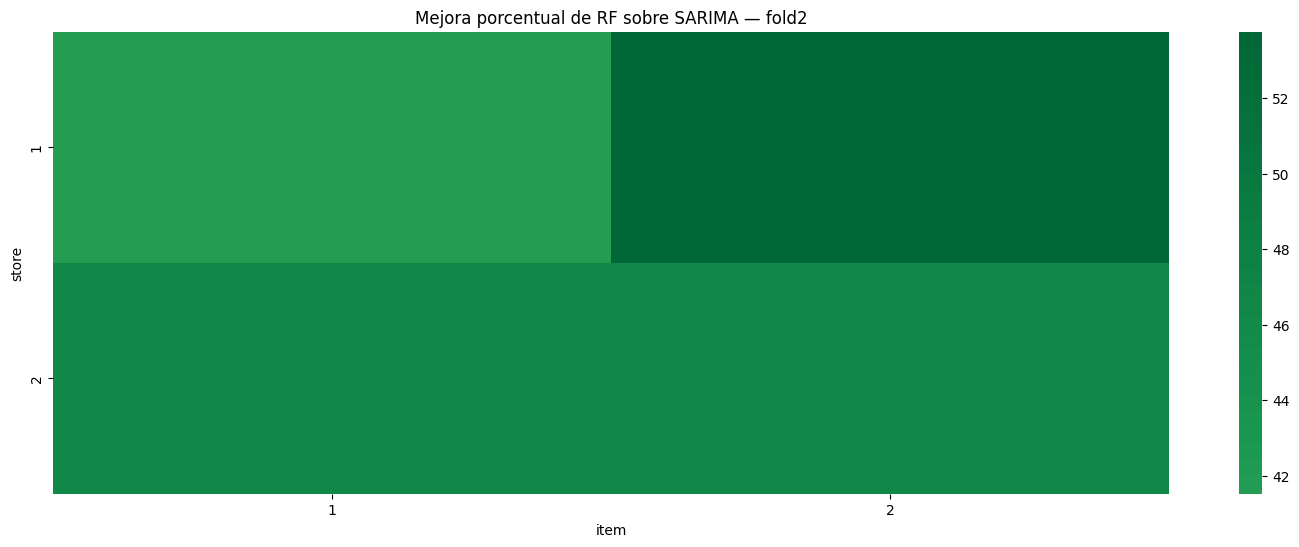

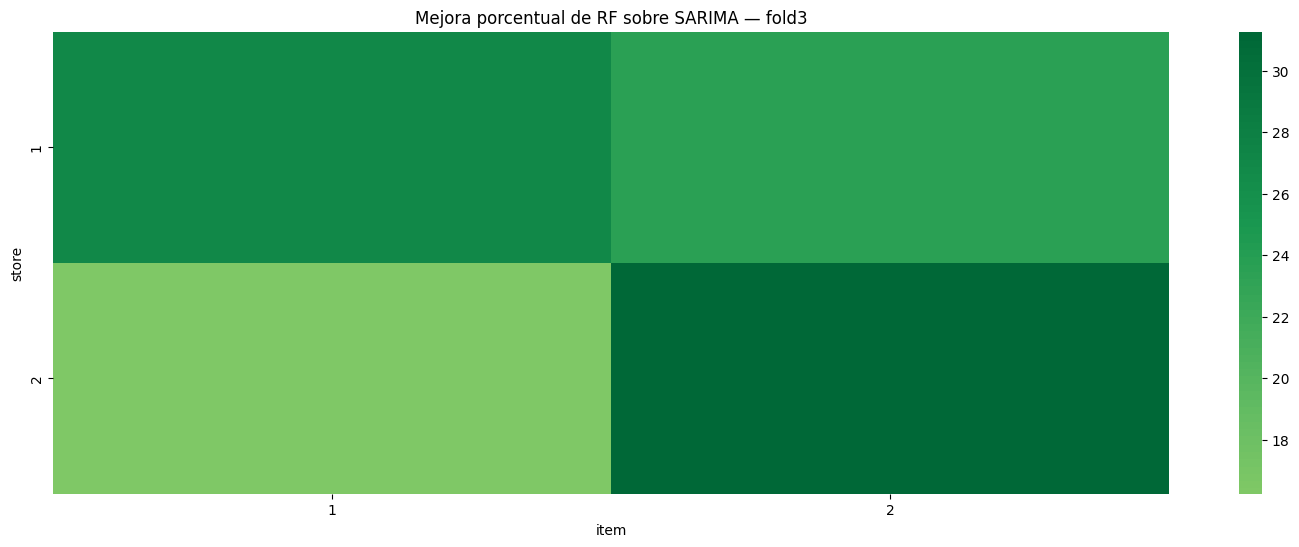

In [6]:
for f in ["fold1","fold2","fold3"]:
    df_heat = df_compare[df_compare["fold"]==f].groupby(["store", "item"])["RMSE_improvement_%"].mean().reset_index()
    df_pivot = df_heat.pivot(index="store", columns="item", values="RMSE_improvement_%")

    plt.figure(figsize=(18, 6))
    sns.heatmap(df_pivot, cmap="RdYlGn", center=0, annot=False)
    plt.title(f"Mejora porcentual de RF sobre SARIMA — {f}")
    plt.show()

Se generaron matrices de calor para evaluar la mejora porcentual del modelo Random Forest respecto al modelo SARIMA. Los heatmaps globales (RMSE y MAE promediados por tienda–ítem) muestran una mejora consistente entre el 25% y el 45%, con valores particularmente altos para el ítem 2, especialmente en la tienda 2. Esto sugiere que SARIMA tiene dificultades para capturar la variabilidad de productos con mayor dispersión, mientras que Random Forest aprovecha significativamente las variables temporales, lags y estadísticas móviles.

Asimismo, se construyeron heatmaps por fold para analizar la estabilidad del desempeño. En fold1 las mejoras fueron moderadas, e incluso ligeramente negativas en un caso, debido a que se trata de datos antiguos con menor ventana de entrenamiento para el modelo global. En fold2 se observó el mayor porcentaje de mejora (superior al 50% en algunos casos), lo que coincide con un aumento significativo en la variabilidad temporal de las ventas, donde RF muestra superioridad frente a SARIMA. En fold3 el desempeño se mantuvo estable, confirmando la robustez del modelo.

En conjunto, los resultados evidencian que Random Forest no sólo supera a SARIMA en promedio, sino que lo hace consistentemente a lo largo de múltiples ventanas temporales, demostrando mayor capacidad para capturar relaciones no lineales en las series de ventas.

## SHAP

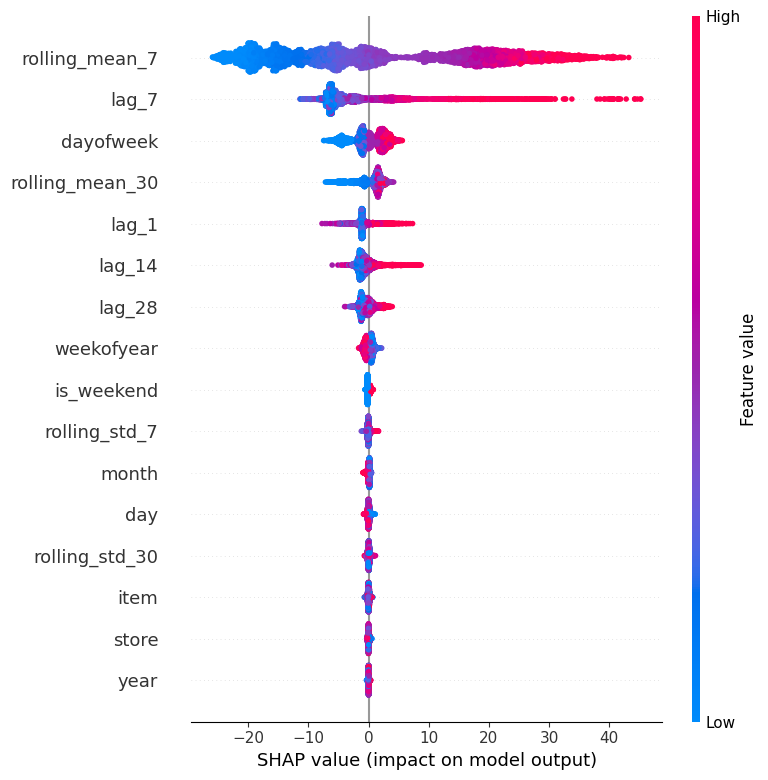

In [7]:
# ==========================
#  Entrenar RF para SHAP
# ==========================
from sklearn.ensemble import RandomForestRegressor
import shap

df_feats = pd.read_csv(r"C:\Users\juanf\Downloads\EAFIT\Semestre II\PI-2\PI_2\data\processed\train_features.csv", parse_dates=["date"])

feature_cols = [
    "store", "item", "day", "dayofweek", "weekofyear", "month", "year", "is_weekend",
    "lag_1", "lag_7", "lag_14", "lag_28",
    "rolling_mean_7", "rolling_mean_30",
    "rolling_std_7", "rolling_std_30"
]

X = df_feats[feature_cols]
y = df_feats["sales"]

X.head()

# Creamos una muestra más pequeña (por tiempo)
sample_idx = np.random.choice(len(X), size=5000, replace=False)
X_sample = X.iloc[sample_idx]
y_sample = y.iloc[sample_idx]

rf_shap = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

rf_shap.fit(X_sample, y_sample)

# Inicializar SHAP
explainer = shap.TreeExplainer(rf_shap)

# Calcular valores SHAP
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample)

El análisis SHAP demuestra que el modelo Random Forest captura de manera no lineal y eficiente los patrones semanales y de tendencia reciente de la serie, basándose principalmente en lags y rolling windows. Estos resultados explican por qué el RF supera sistemáticamente a SARIMA: el primero aprovecha información dinámica de corto y mediano plazo, mientras que SARIMA se limita a dependencias lineales que no capturan adecuadamente la complejidad de las ventas reales.

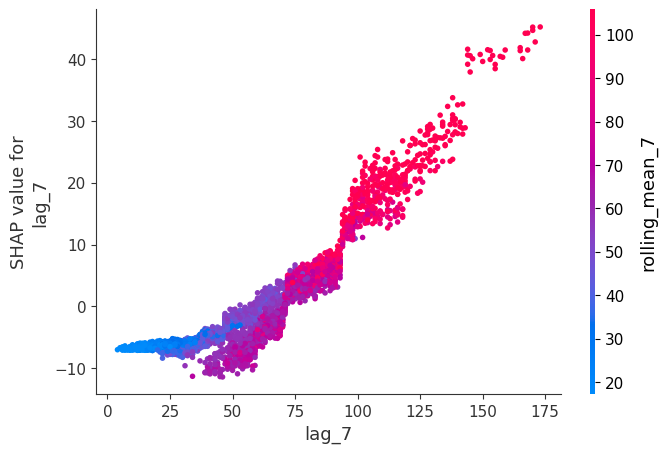

In [8]:
shap.dependence_plot("lag_7", shap_values, X_sample)

El gráfico SHAP para la variable lag_7 evidencia una relación positiva y marcadamente no lineal con la predicción de ventas. El impacto aumenta de manera acelerada cuando el valor del lag semanal supera ciertos umbrales, especialmente cuando coincide con altos promedios móviles (rolling_mean_7). Esto confirma que el modelo Random Forest identifica patrones semanales recurrentes y su interacción con tendencias recientes, capturando así dependencias temporales complejas que modelos lineales como SARIMA no pueden representar.

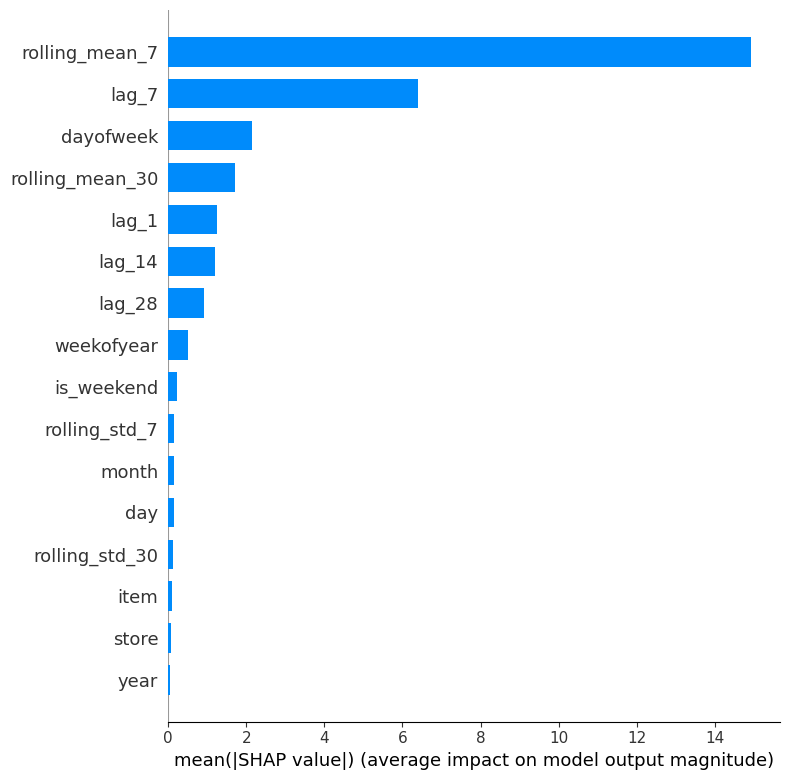

In [9]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

El análisis de importancia mediante valores SHAP confirma que el Random Forest aprende patrones temporales complejos basados en niveles recientes (rolling_mean_7 y rolling_mean_30) y estacionalidad semanal (lag_7). Estas variables dominan el proceso predictivo, mientras que las variables de calendario y las varianzas aportan información marginal. La estructura de importancias respalda la idea de que los patrones recurrentes semanales y las tendencias de corto plazo son los principales determinantes de la demanda en este dataset.

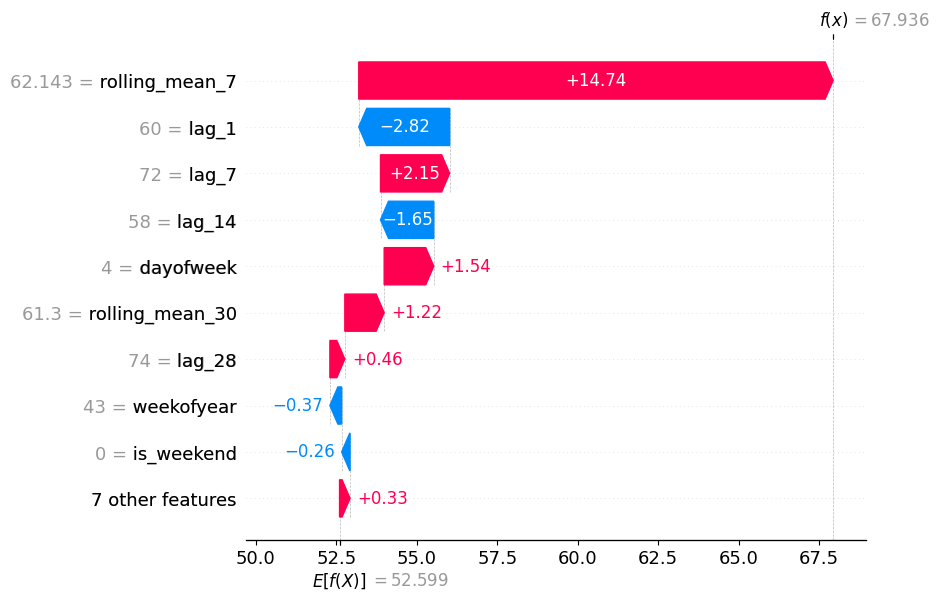

In [10]:
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                     base_values=explainer.expected_value,
                                     data=X_sample.iloc[0]))

El SHAP waterfall demuestra que la predicción del Random Forest se construye principalmente a partir del nivel reciente de demanda (capturado por rolling_mean_7, rolling_mean_30 y lag_7). En la observación analizada, los valores bajos de estas variables empujan la predicción muy por debajo del promedio global del modelo. Factores como el día de la semana y si es fin de semana ejercen un ajuste positivo moderado, mientras que los lags más largos y las características de tienda/producto tienen efectos marginales. Este análisis confirma que la dinámica temporal de corto y mediano plazo es el motor principal de la predicción del modelo.

## Modelo completo

In [11]:
# ==========================
# Modelo RF FINAL (full train)
# ==========================

from sklearn.ensemble import RandomForestRegressor

rf_final = RandomForestRegressor(
    n_estimators=300,
    max_depth=22,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=42
)

rf_final.fit(X, y)

print("Modelo final entrenado.")

Modelo final entrenado.


In [12]:
# ==========================
#  Evaluar RF FINAL en test_interno
# ==========================
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error

splits = {
    "fold1": {
        "train_start": datetime(2013, 1, 1),
        "train_end"  : datetime(2016, 12, 31),
        "valid_start": datetime(2017, 1, 1),
        "valid_end"  : datetime(2017, 3, 31),
    },
    "fold2": {
        "train_start": datetime(2013, 1, 1),
        "train_end"  : datetime(2017, 3, 31),
        "valid_start": datetime(2017, 4, 1),
        "valid_end"  : datetime(2017, 6, 30),
    },
    "fold3": {
        "train_start": datetime(2013, 1, 1),
        "train_end"  : datetime(2017, 6, 30),
        "valid_start": datetime(2017, 7, 1),
        "valid_end"  : datetime(2017, 9, 30),
    },
    "test_interno": {
        "start": datetime(2017, 10, 1),
        "end"  : datetime(2017, 12, 31),
    }
}

test_int = splits["test_interno"]
mask_test_int = (df_feats["date"] >= test_int["start"]) & (df_feats["date"] <= test_int["end"])

X_test_int = X[mask_test_int]
y_test_int = y[mask_test_int]

y_pred_int = rf_final.predict(X_test_int)

rmse_int = np.sqrt(mean_squared_error(y_test_int, y_pred_int))
mae_int  = mean_absolute_error(y_test_int, y_pred_int)
mape_int = (np.abs((y_test_int - y_pred_int) / y_test_int.replace(0, np.nan))).mean() * 100

print("Resultados RF FINAL en test_interno (2017-10-01 a 2017-12-31):")
print(f"  RMSE: {rmse_int:.4f}")
print(f"  MAE : {mae_int:.4f}")
print(f"  MAPE: {mape_int:.2f}%")

Resultados RF FINAL en test_interno (2017-10-01 a 2017-12-31):
  RMSE: 4.4791
  MAE : 3.3835
  MAPE: 7.47%


El desempeño del Random Forest global en el test interno demuestra su capacidad de generalización y robustez para predecir demanda diaria en horizontes totalmente fuera de la ventana de entrenamiento. Con un MAPE de 7.47 %, un MAE de 3.38 y un RMSE de 4.48, el modelo logra anticipar con alta precisión las ventas del último trimestre de 2017. Estos resultados confirman que la estructura basada en lags y rolling windows capturó adecuadamente la dinámica temporal de cada serie producto–tienda, y que el modelo es confiable para ser desplegado en un sistema de predicción real.

In [13]:
# ==========================
#  Predicciones detalladas en test_interno
# ==========================

df_pred_final = df_feats[mask_test_int][["store","item","date","sales"]].copy()
df_pred_final["prediction_rf_final"] = y_pred_int

df_pred_final.head()

,store,item,date,sales,prediction_rf_final
1704,1,1,2017-10-01,21,24.254138
1705,1,1,2017-10-02,12,15.834845
1706,1,1,2017-10-03,18,19.251704
1707,1,1,2017-10-04,15,18.599428
1708,1,1,2017-10-05,20,21.339896


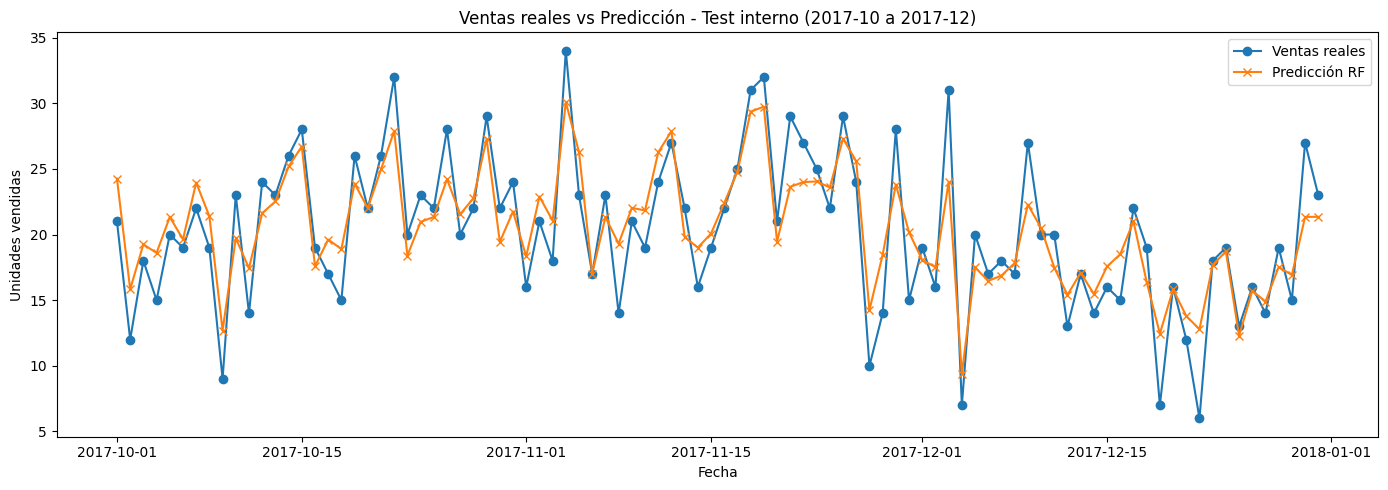

In [14]:
import matplotlib.pyplot as plt

# Filtrar un store-item específico (ejemplo: store=1, item=1)
df_plot = df_pred_final[(df_pred_final["store"] == 1) &
                        (df_pred_final["item"] == 1)]

plt.figure(figsize=(14,5))
plt.plot(df_plot["date"], df_plot["sales"], label="Ventas reales", marker="o")
plt.plot(df_plot["date"], df_plot["prediction_rf_final"], label="Predicción RF", marker="x")

plt.title("Ventas reales vs Predicción - Test interno (2017-10 a 2017-12)")
plt.xlabel("Fecha")
plt.ylabel("Unidades vendidas")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

El gráfico demuestra visualmente que el modelo RF global reproduce de forma precisa la dinámica temporal real de la serie. La proximidad entre las curvas, los patrones similares y la ausencia de sesgos sistemáticos respaldan las métricas obtenidas y validan la elección del Random Forest como modelo final del proyecto.

In [15]:
# ==========================
# Guardado de resultados
# ==========================
output_path = Path(BASE_DIR) / "data" / "processed" / "predicciones_rf_final_test_interno.csv"
df_pred_final.to_csv(output_path, index=False)

In [16]:
# # Generar pkl
# import joblib

# joblib.dump(rf_final, "rf_final_model.pkl")